## Imoports

In [2]:
# general imports 
import allensdk
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline 

# ephys analysis packages
from neo.core import SpikeTrain
from quantities import ms, s, Hz
from elephant.statistics import time_histogram, instantaneous_rate,  mean_firing_rate
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import cross_correlation_histogram


# set data path
import sys
import platform
import os
from os.path import join as pjoin
from pathlib import Path
sys.path.insert(0, '/code/src')

# import our functions
# import importlib
# import plot_utils
# from data_utils import process_nwb_metadata, get_stim_window, get_spike_counts_all
# from plot_utils import plot_area_psth_and_raster, plot_multi_area_psth_and_raster, build_area_packet
# from plot_utils import create_raster, plot_area_psth_and_raster

## Load data from ALLEN SDK

In [3]:
platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
data_root = Path(data_dir)
print('data directory set to', data_dir)

data directory set to /data/


In [4]:
# Visual Behavior Neuropixels 
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

cache_dir = '/root/capsule/data/'

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=True)

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
ecephys_session_table = cache.get_ecephys_session_table() # ephys data

## Select session

In [ ]:
def extract_relevant_session_info(cache, table_type='ecephys', verbose=False):
    # table_type: 'ecephys', 'ecephys_strict', 'behavior'
    
    if table_type == 'behavior':
        session_table = cache.get_behavior_session_table() 
        session_table_final = session_table[(session_table.session_type.str.startswith('EPHYS')) & 
                                            # (behavior_session_table.genotype=='wt/wt') & ## genotypes okay for ephys
                                            (session_table.session_type.str.contains('3uL')) ## 5 uL: not motivated long enough
                                            ]
    elif 'ecephys' in table_type:
        # Filter only for mice that are (i) trained on set G, (ii) tested on first G ('familiar'), then H ('novel').
        session_table = cache.get_ecephys_session_table() 
        session_table_final = session_table[((session_table.session_type.str.startswith('EPHYS')) 
                                                # & (behavior_session_table.genotype=='wt/wt')          ## genotypes okay for ephys
                                                & (session_table.session_type.str.contains('3uL')))     ## 5 uL: not motivated long enough
                                            & ((session_table.image_set=='G') 
                                                & (session_table.experience_level=='Familiar') 
                                                & (session_table.session_number==1)) 
                                            | ((session_table.image_set=='H') 
                                                & (session_table.experience_level=='Novel') 
                                                & (session_table.session_number==2))
                                            ]
        
        if 'strict' in table_type:
            # Get mice that only have both session types
            full_session_mice_idx = np.where(session_table_final['mouse_id'].value_counts()==2)[0]
            full_session_mice     = list(session_table_final['mouse_id'].value_counts().index[full_session_mice_idx])
            session_table_final   = session_table_final[session_table_final.mouse_id.isin(full_session_mice)]
    
    if verbose:
        print(f'Unique genotypes: {session_table_final.genotype.unique()}')
        print(f'Unique session types: {session_table_final[["session_type"]].value_counts()}')
        print(f'Number of sessions: {len(session_table_final)}')
        print(f'Number of mice: {session_table_final[["mouse_id"]].value_counts()}')
        
    return session_table_final



## Filter sessions based on performance metrics ##
def filter_valid_sessions(ecephys_session_table, thresh_perc_engaged = 0.6, thresh_dur_engaged = 0.6, verbose=False):
# thresh_perc_engaged = 0.6 # only sessions that have more than thresh_perc_engaged during engagement period are included in analysis [y-axis, stats 1]
# thresh_dur_engaged = 0.6 # only sessions that are engaged for longer than thresh_dur_engaged are included in analysis [x-axis, stat 2]

    ecephys_session_table['perc_last_disengagement'] = ecephys_session_table['trial_last_disengagement'] / ecephys_session_table['trial_number']

    valid_sessions = ecephys_session_table.loc[(ecephys_session_table.perc_engaged_strict > thresh_perc_engaged) \
                                                    & (ecephys_session_table.perc_last_disengagement > thresh_dur_engaged)]
    valid_session_ids = list(valid_sessions['behavior_session_id'].values)

    if verbose:
        print(f'Valid sessions ({len(valid_session_ids)})\n')
        print(valid_session_ids)

    return valid_sessions, valid_session_ids, ecephys_session_table

In [13]:
# Get good behavioral sessions
ecephys_session_table_final = extract_relevant_session_info(cache, table_type='ecephys_strict', verbose=False)

In [15]:
# get only the novel ephys sessions
novel_sessions=ecephys_session_table_final.loc[ecephys_session_table_final['experience_level']=='Novel'] 
novel_sessions_ids = novel_sessions.index       # get indexes of sessions            

In [16]:
# Get a single session
a_novel_session_id = novel_sessions_ids[0] # from ephys ids
a_novel_session = cache.get_ecephys_session(ecephys_session_id=a_novel_session_id)

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [20]:
# Extract spike times
spike_times_dic = a_novel_session.spike_times

## Select good units

In [17]:
#Good units filter
units = a_novel_session.get_units()
channels = a_novel_session.get_channels()
unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)
good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))
good_units = unit_channels.loc[good_unit_filter]
good_units_list= good_units.index # get names of good units 

good_units.groupby("structure_acronym").apply(lambda g: g.index.unique())

structure_acronym
APN      Int64Index([1053056718, 1053056472, 1053056471...
CA1      Int64Index([1053056574, 1053056595, 1053056730...
CA3      Int64Index([1053057506, 1053057482, 1053057481...
DG       Int64Index([1053056509, 1053056782, 1053056726...
HPF      Int64Index([1053057226, 1053057224, 1053057225...
LGv      Int64Index([1053057462, 1053057461, 1053057421...
MB       Int64Index([1053056493, 1053056489, 1053056492...
MGd      Int64Index([1053057804, 1053057809, 1053057805...
MGm      Int64Index([1053058380, 1053058078, 1053058084...
MGv      Int64Index([1053057699, 1053057706, 1053057702...
MRN      Int64Index([1053057060, 1053058058, 1053058057...
POST     Int64Index([1053057218, 1053057217, 1053057342...
ProS     Int64Index([1053057034, 1053056878, 1053056877...
SCig     Int64Index([1053057176, 1053057185, 1053057193...
TH       Int64Index([1053058069, 1053058064, 1053058068...
VISal    Int64Index([1053057949, 1053057995, 1053057992...
VISam    Int64Index([1053056660, 10530

## Plot correlograms by brain region

In [ ]:
### caution different sessions have different areas!!!

In [18]:
# brain areas
visual_cortex= ['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl'] # primary, lateral, anterolateral, posteromedial, rostorlateral
# hippocampus = ['HPF', 'CA1', 'CA3', 'DG', 'POST','PP']  #  dentate gyrus, umbrella,  postsubiculum, parasubiculum, 
hippocampus = ['HPF', 'CA1', 'CA3', 'DG', 'POST']  # 'PP' 
# thalamus =  ['MGd','MGv', 'MGm', 'LP', 'PIL',  'POL', 'TH']   #general, lateralposterior, posterior intralaminar, medial division, dorsal division, posterior thalamic nucleus
thalamus =  [ 'MGm', 'LP', 'PIL',  'POL', 'TH']   # 'MGd','MGv'
midbrain = ['SCig', 'MB',  'MRN', 'SNr'] #superior colliculus  midbrain reticular nucleus, midbrain umbrella, #substantia nigra
regions = [visual_cortex, hippocampus, thalamus, midbrain]


In [22]:
def generate_autocorr_data(spiketrain, bin_size, autocorr_win):
    binned_spiketrain = BinnedSpikeTrain([spiketrain], bin_size=bin_size * ms)
    autocorr, bins_auto = cross_correlation_histogram(binned_spiketrain, binned_spiketrain, window=[-int(autocorr_win), int(autocorr_win)])
    autocorr_array, bins_auto = np.delete(autocorr.magnitude.flatten(), bins_auto == 0), np.delete(bins_auto, bins_auto == 0)
    return bins_auto, autocorr_array

['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']
VISp


/opt/conda/lib/python3.9/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']
VISl
['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']
VISal
['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']
VISpm
['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']
VISrl
['HPF', 'CA1', 'CA3', 'DG', 'POST']
HPF
['HPF', 'CA1', 'CA3', 'DG', 'POST']
CA1


[2025-09-03 18:02:37,754] utils - WARNING: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
/opt/conda/lib/python3.9/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


['HPF', 'CA1', 'CA3', 'DG', 'POST']
CA3
['HPF', 'CA1', 'CA3', 'DG', 'POST']
DG


/opt/conda/lib/python3.9/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


['HPF', 'CA1', 'CA3', 'DG', 'POST']
POST
['MGm', 'LP', 'PIL', 'POL', 'TH']
MGm
['MGm', 'LP', 'PIL', 'POL', 'TH']
LP


ValueError: need at least one array to concatenate

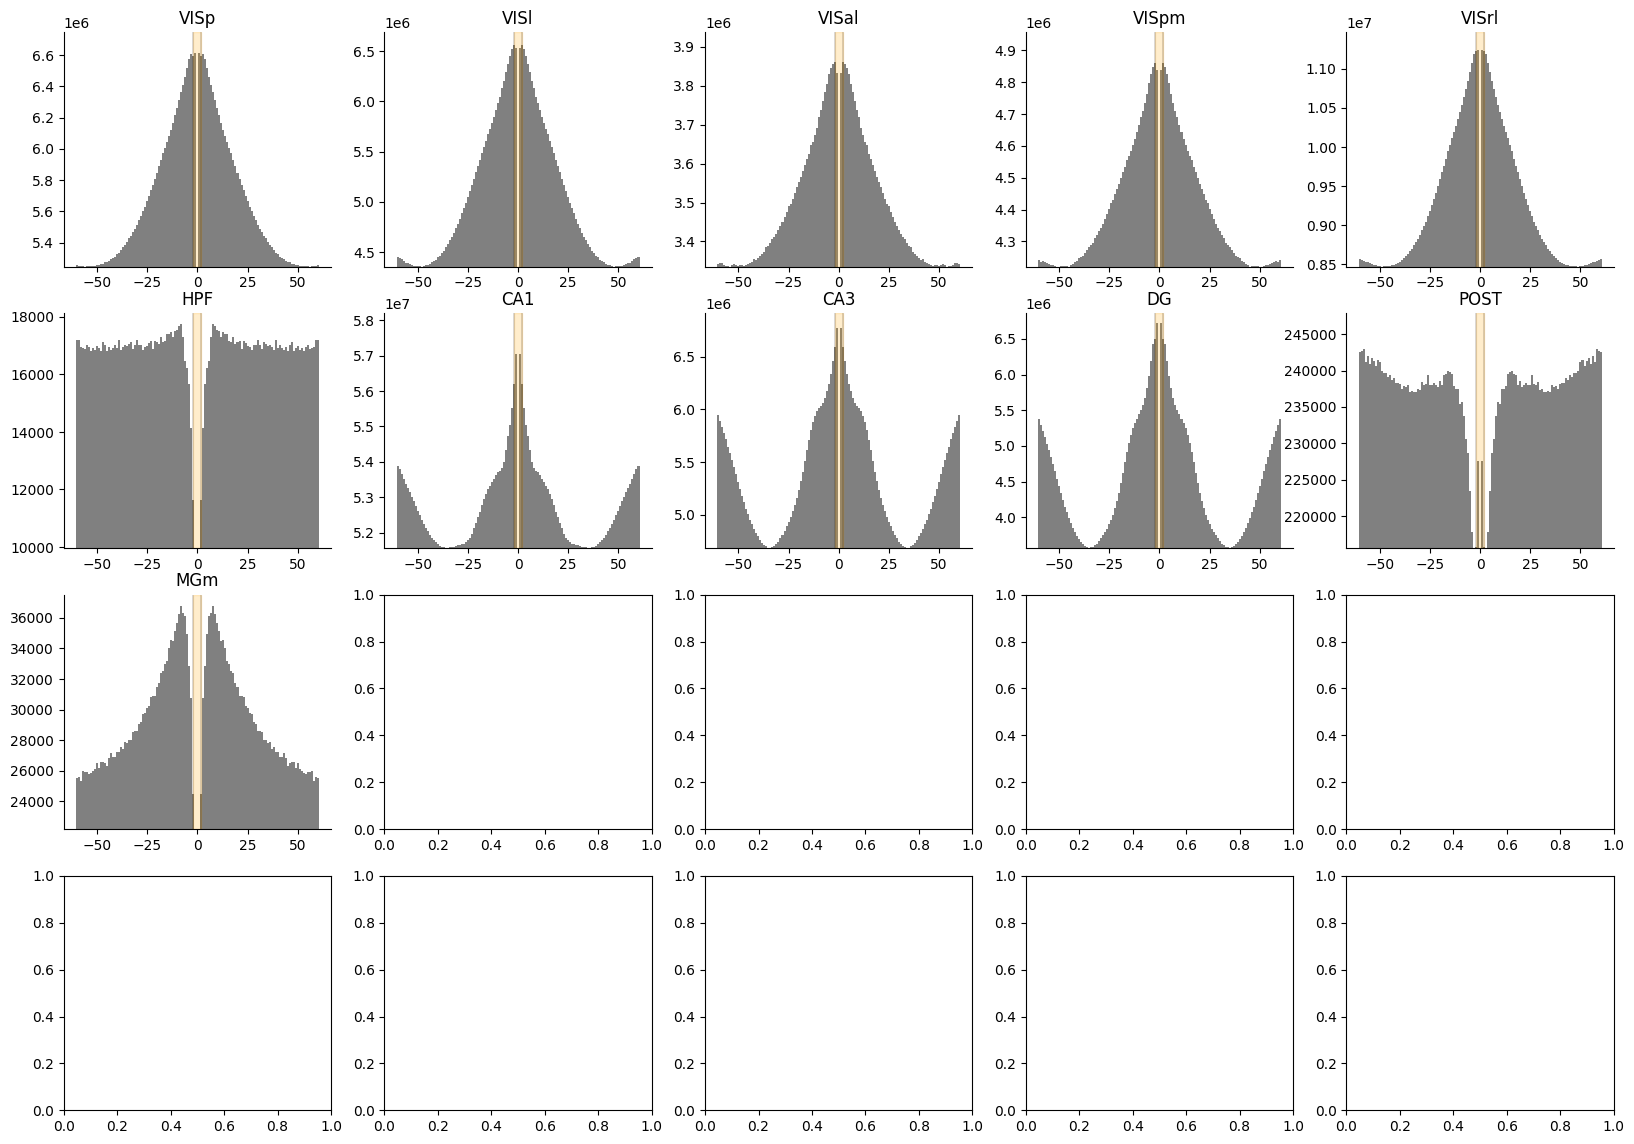

In [23]:
bin_size, sdev, autocorr_win,  = 1, 50, 60, # Convolution parameters (ms)

fig, ax = plt.subplots(nrows=4,ncols=5, figsize=(20, 14))
ax=ax.flatten()

for idy, region in enumerate (regions): # loop though sessions
    for idx, area in enumerate(region): # areas inside the region
        print(region)
        print(area)

        
        i = idx+idy*5        
        # Get all the spiketimes of a single region
        units_region= good_units.loc[good_units['structure_acronym']==area] # select units inside the area
        spike_times_region= []  # list of 1D arrays per unit
        for unit in units_region.index: #get spike times for each unit of the region
            spike_times= spike_times_dic[unit] #timestamps of the specific unit
            spike_times_region.append(spike_times) 
        spike_times_region_arr = np.concatenate(spike_times_region) # append all spiketimes of the region in a single array
    
        # print(region)
        # print('Nº of units ' +str(units_region.shape[0]))
        # print('')

        # create the spiketrain
        spiketrain = SpikeTrain(spike_times_region_arr * 1000 * ms,
                            t_stop=spike_times_region_arr.max() * 1000 * ms,
                            t_start=spike_times_region_arr.min() * 1000 * ms) 
        # autocorrelogram
        bins_auto, autocorr_array = generate_autocorr_data(spiketrain, bin_size+1, autocorr_win)
        
        
        #plot
        ax[i].bar(bins_auto, autocorr_array, width=1, color='gray', linewidth=0.3)
        ax[i].axvspan(-2, 2, color='orange', alpha=0.2) # refractory period (isi)
        ax[i].set_title(area)
        if idy==3:
            ax[i].set_xlabel('Time (ms)') 
        else:
            ax[i].set_xlabel('') 

        ax[i].axvline(2, color='black', linewidth=0.2)
        ax[i].axvline(-2, color='black', linewidth=0.2)
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ymax = np.nanmax(autocorr_array) 
        ylow = np.nanpercentile(autocorr_array, 0.5) 
        # safety guards
        if not np.isfinite(ymax):  # empty or all-NaN
            ymax, ylow = 1.0, 0.0
        if ylow >= ymax:
            ylow = 0.95 * ymax  # tiny margin below the top
        ax[i].set_ylim(ylow, ymax * 1.02) 

## Extract sync measurements

In [25]:
def bin_unit_ms(spikes_s, t0, t1, bin_size):
    '''takes a list/array of spike times in seconds and converts them into a histogram of spike counts per millisecond bin'''
    st_ms = np.round(np.asarray(spikes_s)*1000).astype(np.int64) # spiketimes to milliseconds
    t0_ms, t1_ms = int(np.floor(t0*1000)), int(np.ceil(t1*1000)) # start and stop times to milliseconds
    edges = np.arange(t0_ms, t1_ms + bin_ms, bin_ms, dtype=np.int64)
    hist, _ = np.histogram(st_ms, bins=edges)
    return hist.astype(float)

def mean_pairwise_corr(spike_times, bin_ms=5):
    """
    spike_times: dict {unit_name: array_seconds} or list of arrays
    returns mean Pearson correlation across unit pairs
    """
    vals = spike_times.values() if isinstance(spike_times, dict) else spike_times
    units = [np.asarray(u, float) for u in vals if len(u)>0]
    if len(units) < 2: return np.nan

    t0 = min(u.min() for u in units); t1 = max(u.max() for u in units)
    X = np.vstack([bin_unit_ms(u, t0, t1, bin_ms) for u in units])  # shape: [U, T]

    # Z-score each unit to reduce firing-rate bias
    X = (X - X.mean(1, keepdims=True)) / (X.std(1, keepdims=True) + 1e-9)

    C = np.corrcoef(X)  # [U,U]
    iu = np.triu_indices_from(C, k=1)
    return np.nanmean(C[iu])


for idy, region in enumerate (regions): # loop though sessions
    for idx, area in enumerate(region): # areas inside the region
        print(region)
        print(area)
     
        # Get all the spiketimes of a single region
        units_region= good_units.loc[good_units['structure_acronym']==area] # select units inside the area
        spike_times_region= []  # list of 1D arrays per unit
        for unit in units_region.index: #get spike times for each unit of the region
            spike_times= spike_times_dic[unit] #timestamps of the specific unit
            spike_times_region.append(spike_times) 
        spike_times_region_arr = np.concatenate(spike_times_region) # append all spiketimes of the region in a single array
        
        spite_times_bin = bin_unit_ms(spike_times_region_arr, spike_times_region_arr.min(), spike_times_region_arr.max())
    

['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl']
VISp


TypeError: bin_unit_ms() missing 3 required positional arguments: 't0', 't1', and 'bin_ms'